<a href="https://colab.research.google.com/github/nonotoy/yubimoji_palm/blob/main/yubimoji_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare

#### 0_Install

In [1]:
!pip install tensorflow==2.16.1 scikeras #keras torch==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
    

In [2]:
!pip install seaborn matplotlib

In [3]:
#pip uninstall scikeras keras tensorflow -y

In [4]:
##pip install scikeras==0.13.0 keras==3.2.1 tensorflow==2.16.1 scikit-learn==1.4.2

#### 1_Library

In [5]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

import scikeras
print("scikeras version:", scikeras.__version__)

import keras
print("keras version:", keras.__version__)

import tensorflow
print("tensorflow version:", tensorflow.__version__)

scikit-learn version: 1.4.2
scikeras version: 0.13.0
keras version: 3.3.2
tensorflow version: 2.16.1


In [6]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.16.1
GPU available: True


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import csv

import numpy as np

# keras
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Lambda
from keras.regularizers import l2
from keras.utils import to_categorical
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7689324727456301857
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 21991653376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 945523556368959979
 physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
 xla_global_id: 416903419]

#### 2_Common def

In [8]:
# Common parameters
n_sequence = 15  # シーケンス長
n_classes = 76 # 出力クラス (指文字) の数

def setup_pathandparams(mode):

    if mode == 0:
        withPalm = True
        palmNormlized = True

        # 手掌長あり & 手掌長正規化
        dataset = '/content/drive/Othercomputers/My Mac/Documents/2_study/1_修士/3_副研究/point_history/normalised__point_history_normalisedpalm_combined.csv'
        model_save_path = '/content/drive/MyDrive/Colab Notebooks/JSL/gesture_classifier_0'

        # Parameters
        n_features = 41  # 特徴量の数 (ランドマークx, y 各20列 + 手掌長 1列)

    elif mode == 1:
        withPalm = True
        palmNormlized = False

        # 手掌長あり
        dataset = '/content/drive/Othercomputers/My Mac/Documents/2_study/1_修士/3_副研究/point_history/normalised__point_history_palm_combined.csv'
        model_save_path = '/content/drive/MyDrive/Colab Notebooks/JSL/gesture_classifier_1'

        # Parameters
        n_features = 41  # 特徴量の数 (ランドマークx, y 各20列 + 手掌長 1列)

    elif mode == 2:
        withPalm = False
        palmNormlized = False

        # 手掌長なし
        dataset = '/content/drive/Othercomputers/My Mac/Documents/2_study/1_修士/3_副研究/point_history/normalised__point_history_combined.csv'
        model_save_path = '/content/drive/MyDrive/Colab Notebooks/JSL/gesture_classifier_2'

        # Parameters
        n_features = 40  # 特徴量の数 (ランドマークx, y 各20列)

    return withPalm, palmNormlized, dataset, model_save_path, n_features

### Train model

In [14]:
def createLSTMModel():

    regularizer = l2(0.001)

    # ElasticNet正則化の設定
    #l1_ratio = 0.05 # L1正則化の割合 (0 < l1_ratio < 1)
    #regularizer = l1_l2(l1=0.001 * l1_ratio, l2=0.001 * (1-l1_ratio))

    '''model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_sequence, n_features)),
        MaxPooling1D(pool_size=2),
        LSTM(512, return_sequences=False, kernel_regularizer=regularizer),
        Dense(512, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])'''

    model = Sequential([
        Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_sequence, n_features)),
        MaxPooling1D(pool_size=2),
        #LSTM(2048, return_sequences=True, kernel_regularizer=regularizer),
        #Bidirectional(LSTM(1024, return_sequences=True, kernel_regularizer=regularizer)),
        #Bidirectional(LSTM(512, return_sequences=False, kernel_regularizer=regularizer)),
        LSTM(1024, return_sequences=True, kernel_regularizer=regularizer),
        LSTM(512, return_sequences=False, kernel_regularizer=regularizer),
        #Dense(512, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        #Dropout(0.2),
        Dense(256, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizer),
        #BatchNormalization(),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])


    '''model = Sequential([
            Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=regularizer, bias_regularizer=regularizer, input_shape=(n_sequence, n_features)),
            MaxPooling1D(pool_size=2),
            LSTM(512, return_sequences=True, kernel_regularizer=regularizer, recurrent_regularizer=regularizer, bias_regularizer=regularizer),
            LSTM(256, return_sequences=True, kernel_regularizer=regularizer, recurrent_regularizer=regularizer, bias_regularizer=regularizer),
            LSTM(128, return_sequences=False, kernel_regularizer=regularizer, recurrent_regularizer=regularizer, bias_regularizer=regularizer),
            BatchNormalization(),
            Dropout(0.2),
            Dense(128, activation='relu', kernel_regularizer=regularizer, bias_regularizer=regularizer),
            BatchNormalization(),
            Dropout(0.2),
            Dense(64, activation='relu', kernel_regularizer=regularizer, bias_regularizer=regularizer),
            BatchNormalization(),
            Dropout(0.2),
            Dense(n_classes, activation='softmax')
        ])'''

    model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
y_test_0 = ''
y_test_1 = ''
y_test_2 = ''
X_test_0 = ''
X_test_1 = ''
X_test_2 = ''

for mode in range(3):

    withPalm, palmNormlized, dataset, model_save_path, n_features = setup_pathandparams(mode)

    # Ground truth label (1st cln)
    y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

    # One-hot encoding of the GT label
    y_dataset = to_categorical(y_dataset, num_classes=n_classes)

    # Training data (2nd cln to the last cln)
    X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, n_features+1))) # (20730, 40) or ,41)

    # サンプル数をシーケンス長で割り切れるように調整
    max_samples = len(X_dataset) - len(X_dataset) % n_sequence

    # Reshape
    X_dataset = X_dataset[:max_samples]
    y_dataset = y_dataset[:max_samples]
    X_dataset = X_dataset.reshape(-1, n_sequence, n_features)
    y_dataset = y_dataset.reshape(-1, n_sequence, n_classes)

    print('withPalm: ', withPalm, '| palmNormlized: ', palmNormlized)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path + '_bilstm.keras', verbose=0, save_weights_only=False)
    es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=0)

    X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=42)
    y_train = np.argmax(y_train[:, -1, :], axis=1)
    y_test = np.argmax(y_test[:, -1, :], axis=1)

    if mode == 0:
        X_test_0 = X_test
        y_test_0 = y_test
    elif mode == 1:
        X_test_1 = X_test
        y_test_1 = y_test
    elif mode == 2:
        X_test_2 = X_test
        y_test_2 = y_test

    best_model = None
    best_accuracy = 0

    for i in range(10):

        model = createLSTMModel()

        model.fit(
            X_train,
            y_train,
            epochs=1000,
            batch_size=256,
            validation_data=(X_test, y_test),
            callbacks=[cp_callback, es_callback],
            verbose=0)

        _, accuracy = model.evaluate(X_train, y_train, verbose=0)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    y_pred = best_model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)

    print('--------------------')

    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f'Accuracy:\t{best_accuracy:.2f}')
    print(f'Precision:\t{precision:.2f}')
    print(f'Recall:\t\t{recall:.2f}')
    print(f'F1 Score:\t{f1:.2f}')

    best_model.save(model_save_path + '.h5', overwrite=True)
    #best_model.save(new_model_save_path + '.h5', include_optimizer=False, overwrite=True)

    print('--------------------')

withPalm:  True | palmNormlized:  True


--------------------
Accuracy:	0.56
Precision:	0.49
Recall:		0.53
F1 Score:	0.46
--------------------
withPalm:  True | palmNormlized:  False


KeyboardInterrupt: 

### Export model architecture

In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

for mode in range(3):
    # load model
    model = load_model('/content/drive/MyDrive/Colab Notebooks/JSL/gesture_classifier_{}.h5'.format(mode))

    # plot model
    file = str('/content/drive/Othercomputers/My Mac/Documents/2_study/1_修士/3_副研究/report/model_{}.png'.format(mode))
    plot_model(model=model, show_shapes=True, expand_nested=True, to_file=file)

    # save svg
    SVG(data=model_to_dot(model).create(prog='dot', format='svg'))

### Confusion matrix

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


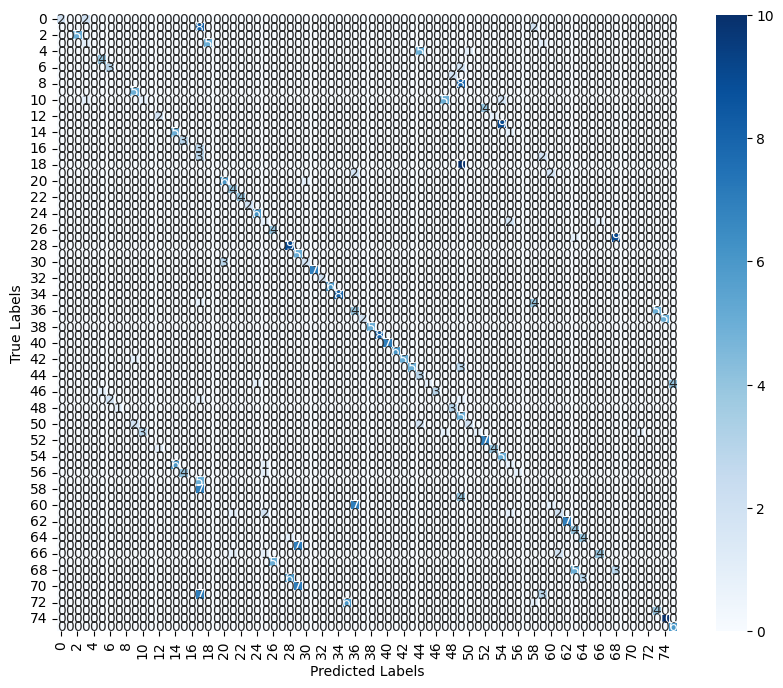

--------------------
Accuracy: 0.4934
Precision: 0.4677
Recall: 0.4934
F1 Score: 0.4392


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Colab Notebooks/JSL/gesture_classifier_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

for i in range(1):
    model = load_model('/content/drive/MyDrive/Colab Notebooks/JSL/gesture_classifier_{}.h5'.format(i))

    if i == 0:
        X_test_ = X_test_0
        y_test_ = y_test_0
    elif i == 1:
        X_test_ = X_test_1
        y_test_ = y_test_1
    elif i == 2:
        X_test_ = X_test_2
        y_test_ = y_test

    predictions = model.predict(X_test_)
    predicted_classes = np.argmax(predictions, axis=1)

    cm = confusion_matrix(y_test_, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    #plt.savefig('confusion_matrix.svg', format='svg')
    #plt.close()

    accuracy = accuracy_score(y_test_, predicted_classes)
    precision = precision_score(y_test_, predicted_classes, average='weighted')
    recall = recall_score(y_test_, predicted_classes, average='weighted')
    f1 = f1_score(y_test_, predicted_classes, average='weighted')

    print("-"*20)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [19]:
! pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=ef4af22b7ee50b3e6b694900dd9db3848f73136cf367597a91a2d457bb7bf85b
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


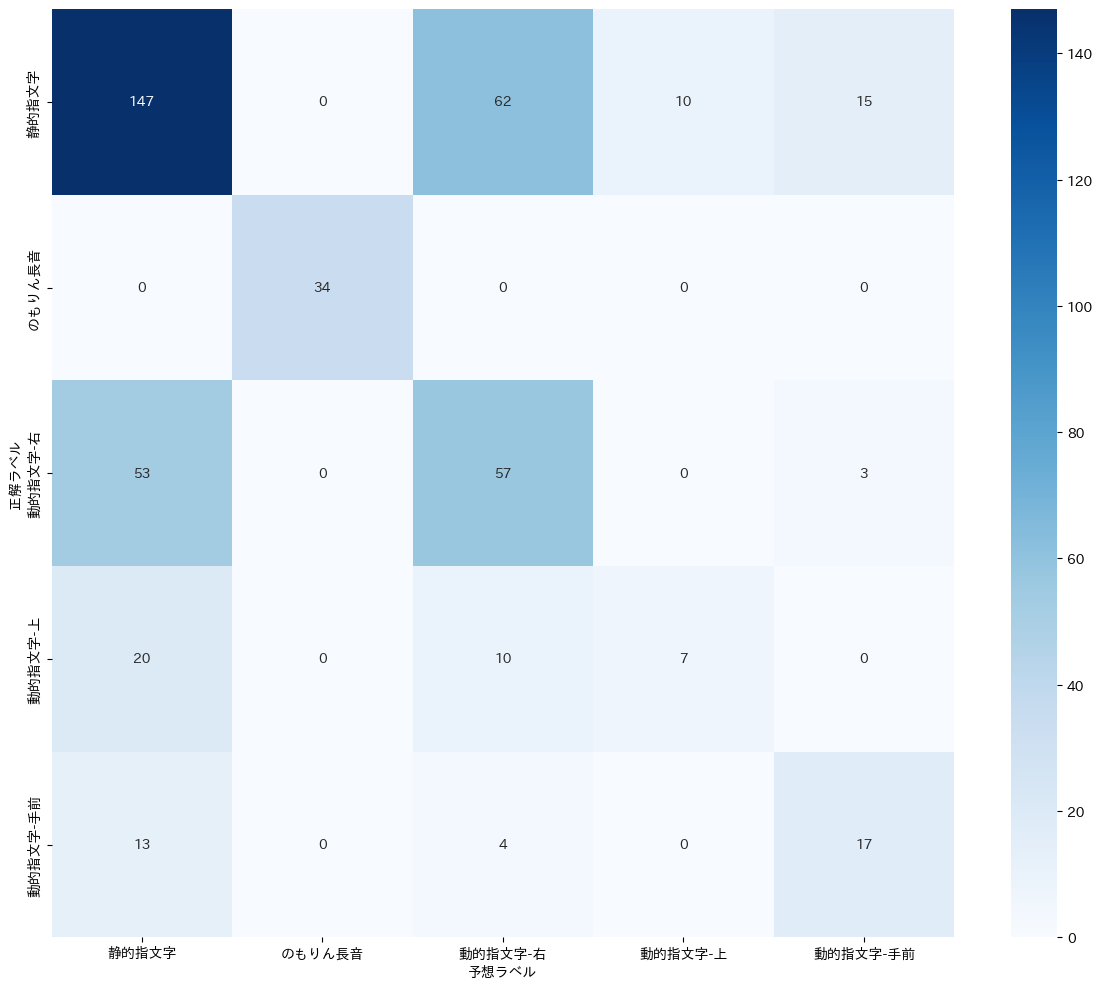

In [20]:
import japanize_matplotlib


# 指定されたグループリストに基づいてラベルをまとめる
def group_labels_by_groups(labels, group_list):
    group_indices = []
    for group in group_list:
        indices = [i for i, label in enumerate(labels) if label in group]
        if indices:
            group_indices.append(indices)
    return group_indices

# 混同行列の作成
cm = confusion_matrix(y_test, predicted_classes)

# ラベルをまとめるグループのリストを指定する
group_list = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43],
    [24, 34, 39, 45, 75],
    [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
    [66, 67, 68, 69, 70],
    [44, 71, 72, 73, 74]
]

group_labels = ['静的指文字', 'のもりん長音', '動的指文字-右', '動的指文字-上','動的指文字-手前']

# 指定されたグループリストに基づいてラベルをまとめる
group_indices = group_labels_by_groups(range(len(cm)), group_list)

# まとめたラベルに基づいて混同行列を集約する
grouped_cm = np.zeros((len(group_indices), len(group_indices)), dtype=int)
for i, row_indices in enumerate(group_indices):
    for j, col_indices in enumerate(group_indices):
        grouped_cm[i, j] = np.sum(cm[row_indices, :][:, col_indices])


# 混同行列の可視化
plt.figure(figsize=(12, 10))
sns.heatmap(grouped_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=group_labels,
            yticklabels=group_labels)
plt.xlabel('予想ラベル')
plt.ylabel('正解ラベル')
plt.tight_layout()
plt.show()

# SVG形式で保存
plt.savefig('custom_grouped_confusion_matrix.svg', format='svg')
plt.close()